In [2]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
)
from PIL import Image, ImageDraw

from monai.visualize import plot_2d_or_3d_image
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Tuple
from monai.transforms.utils import rescale_array


In [9]:
print(monai.__version__)
EXPERIMENT = 'synthetic/' # 'synthetic', 'ISLES', 'BRATS'
ROOT_EXP   = './'
ROOT_DATA = ROOT_EXP + 'data/'+EXPERIMENT
#At insel: /home/sebastian/experiments/fedem/data/'

0.7.0


In [10]:
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

MONAI version: 0.7.0
Numpy version: 1.21.2
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.4.0
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.1
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [11]:
train_dir = ROOT_DATA + 'train/'
val_dir   = ROOT_DATA + 'val/'
test_dir  = ROOT_DATA + 'test/'

In [12]:
imagepaths_train = sorted(glob(os.path.join(train_dir, "*img*.png")))
segmpaths_train   = sorted(glob(os.path.join(train_dir, "*seg*.png")))
print(len(imagepaths_train),len(segmpaths_train))
imagepaths_val = sorted(glob(os.path.join(val_dir, "*img*.png")))
segmpaths_val   = sorted(glob(os.path.join(val_dir, "*seg*.png")))
print(len(imagepaths_val),len(segmpaths_val))
imagepaths_test = sorted(glob(os.path.join(test_dir, "*img*.png")))
segmpaths_test   = sorted(glob(os.path.join(test_dir, "*seg*.png")))
print(len(imagepaths_test),len(segmpaths_test))

90 90
10 10
20 20


In [13]:
# define transforms for image and segmentation
train_imtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)
train_segtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)

In [14]:
val_imtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])
val_segtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

# define array dataset, data loader
check_ds = ArrayDataset(imagepaths_train, train_imtrans, segmpaths_train, train_segtrans)
check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg = monai.utils.misc.first(check_loader)
print(im.shape, seg.shape)

torch.Size([10, 1, 96, 96]) torch.Size([10, 1, 96, 96])


In [15]:
# create a training data loader
train_ds = ArrayDataset(imagepaths_train, train_imtrans, segmpaths_train, train_segtrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())
# create a validation data loader
val_ds = ArrayDataset(imagepaths_val, val_imtrans, segmpaths_val, val_segtrans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())
#create the test data loader
test_ds = ArrayDataset(imagepaths_test, val_imtrans, segmpaths_test, val_segtrans)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_metric_test = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)


post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)])
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [27]:
train_ds[10:20]

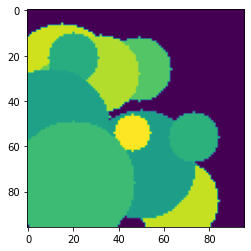

In [26]:
plt.imshow(train_ds[0][0][0].cpu())

In [ ]:
best_val_performances = []
test_performances = []
file_performances_test = open(ROOT_EXP + 'results/performances_dice_'+EXPERIMENT.split('/')[0]+'.txt','w')

for run_num in range(10):
    print(f"Training for run {run_num}")
    model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    loss_function = monai.losses.DiceLoss(sigmoid=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)

    # start a typical PyTorch training
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    metric_values = list()
    metric_values_test = list()
    writer = SummaryWriter()
    for epoch in range(10):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{10}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    roi_size = (96, 96)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    #print("========")
                    #print(val_outputs[0].shape,val_labels[0].shape)
                    dice_metric(y_pred=val_outputs, y=val_labels)
                    #print("========")

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(),ROOT_EXP+"/models/"+EXPERIMENT+"run_" +str(run_num)+"_best_metric_model_segmentation2d_array.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_mean_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")
    best_val_performances.append(best_metric)
    #Evaluation in the test partition
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        roi_size = (96, 96)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        dice_metric_test(y_pred=test_outputs, y=test_labels)
    metric_test = dice_metric_test.aggregate().item()
    dice_metric_test.reset()
    test_performances.append(metric_test)
    print("Dice in Test partition for run " + str(run_num) + str(metric_test))
    file_performances_test.write(str(metric_test)+'\n')
file_performances_test.close()

Training for run 0
----------
epoch 1/10
1/22, train_loss: 0.5072
2/22, train_loss: 0.5238
3/22, train_loss: 0.4466
4/22, train_loss: 0.4102
5/22, train_loss: 0.4305
6/22, train_loss: 0.4142
7/22, train_loss: 0.4545
8/22, train_loss: 0.3924
9/22, train_loss: 0.4170
10/22, train_loss: 0.4241
11/22, train_loss: 0.4376
12/22, train_loss: 0.4176
13/22, train_loss: 0.4146
14/22, train_loss: 0.4217
15/22, train_loss: 0.4247
16/22, train_loss: 0.4268
17/22, train_loss: 0.4107
18/22, train_loss: 0.4309
19/22, train_loss: 0.3806
20/22, train_loss: 0.4206
21/22, train_loss: 0.3655
22/22, train_loss: 0.4186
23/22, train_loss: 0.4069
epoch 1 average loss: 0.4260
----------
epoch 2/10
1/22, train_loss: 0.4170
2/22, train_loss: 0.3602
3/22, train_loss: 0.3686
4/22, train_loss: 0.3831
5/22, train_loss: 0.3913
6/22, train_loss: 0.3711
7/22, train_loss: 0.3570
8/22, train_loss: 0.3738
9/22, train_loss: 0.3505
10/22, train_loss: 0.3574
11/22, train_loss: 0.3562
12/22, train_loss: 0.3669
13/22, train_los

In [24]:
metric_values_test

[0.9900366067886353]

In [ ]:
### print(val_outputs[0].shape, val_labels.shape)

In [14]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

train completed, best_metric: 0.9880 at epoch: 10


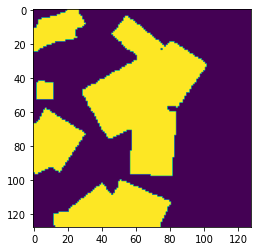

In [16]:
plt.imshow(val_outputs[0][0].cpu().numpy())

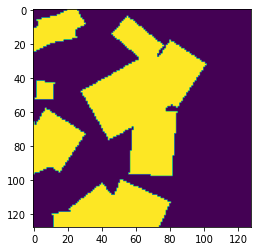

In [17]:
plt.imshow(val_labels[0][0].cpu().numpy())

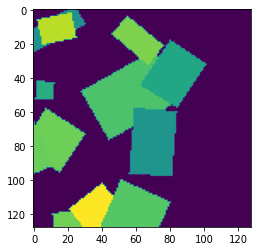

In [20]:
plt.imshow(val_images[0][0].cpu().numpy())

In [27]:
metric

0.972629189491272